## **Email Phishing Detection using NLP + BERT**

In [2]:
# 1. Import libraries
import pandas as pd
import torch
import re, string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ====================================================
# 2. Load JSON dataset
# ====================================================
# JSON must have 'text' and 'label' fields
data = pd.read_json("emails.json")
print("Dataset shape:", data.shape)
print(data.head())
print(data['label'].value_counts())

Dataset shape: (77677, 2)
                                                text  label
0  <!doctypehtml><html lang=en xml:lang=en xmlns=...      0
1                  http://online0mgeving.ga/triodos/      1
2  metronews.ca/webapp/Login.aspx?logout=true&rur...      0
3      https://rarkuntem.co.jp.fpjiehk.cn/index1.php      1
4                        freebase.com/view/m/0ct05qn      0
label
0    44975
1    32702
Name: count, dtype: int64


In [6]:
# ============================
# 3.NLP Preprocessing for Email Phishing Detection
# ============================

def preprocess_email_keep_all(text):
    """
    Preprocess email for BERT:
    - Lowercase
    - Keep everything else (URLs, emails, numbers, punctuation)
    - Optional: remove stopwords (commented out)
    """
    # Lowercase
    text = text.lower()

    # Optional: remove stopwords (uncomment if needed)
    # words = text.split()
    # words = [word for word in words if word not in stop_words]
    # text = ' '.join(words)

    return text

# Apply preprocessing
data['clean_text'] = data['text'].apply(preprocess_email_keep_all)

# Check result
print(data[['text','clean_text']].head())

                                                text  \
0  <!doctypehtml><html lang=en xml:lang=en xmlns=...   
1                  http://online0mgeving.ga/triodos/   
2  metronews.ca/webapp/Login.aspx?logout=true&rur...   
3      https://rarkuntem.co.jp.fpjiehk.cn/index1.php   
4                        freebase.com/view/m/0ct05qn   

                                          clean_text  
0  <!doctypehtml><html lang=en xml:lang=en xmlns=...  
1                  http://online0mgeving.ga/triodos/  
2  metronews.ca/webapp/login.aspx?logout=true&rur...  
3      https://rarkuntem.co.jp.fpjiehk.cn/index1.php  
4                        freebase.com/view/m/0ct05qn  


In [7]:
# ====================================================
# 4. Train-Test Split
# ====================================================
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['clean_text'].tolist(),
    data['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

In [8]:
# ====================================================
# 5. BERT Tokenization
# ====================================================
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
# ====================================================
# 6. Dataset class
# ====================================================
class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = EmailDataset(train_encodings, train_labels)
test_dataset = EmailDataset(test_encodings, test_labels)

In [10]:
# ====================================================
# 7. Load BERT model
# ====================================================
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# ====================================================
# 8. Training Arguments
# ====================================================

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=50,
    save_strategy='epoch',
    report_to='none'  # <-- This disables W&B and other loggers
)


In [20]:
# ====================================================
# 9. Trainer and Training
# ====================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Step,Training Loss
50,0.092800
100,0.076300
150,0.096500
200,0.081100
250,0.096500
300,0.137500
350,0.065900
400,0.101300
450,0.075600
500,0.039300


Step,Training Loss
50,0.092800
100,0.076300
150,0.096500
200,0.081100
250,0.096500
300,0.137500
350,0.065900
400,0.101300
450,0.075600
500,0.039300


TrainOutput(global_step=11652, training_loss=0.045432821831302976, metrics={'train_runtime': 4320.0526, 'train_samples_per_second': 43.153, 'train_steps_per_second': 2.697, 'total_flos': 1.226248806834432e+16, 'train_loss': 0.045432821831302976, 'epoch': 3.0})

Accuracy: 96.43%
Precision: 0.97
Recall: 0.95
F1-Score: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      8995
           1       0.97      0.95      0.96      6541

    accuracy                           0.96     15536
   macro avg       0.96      0.96      0.96     15536
weighted avg       0.96      0.96      0.96     15536



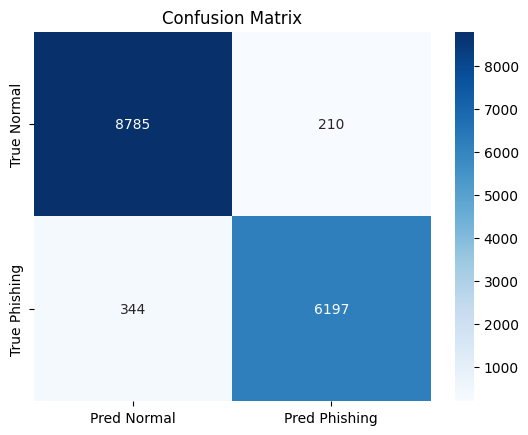

In [21]:
# ====================================================
# 10. Evaluation
# ====================================================
preds_output = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(preds_output.predictions), axis=1).numpy()

# Compute metrics
accuracy = accuracy_score(test_labels, preds)
precision = precision_score(test_labels, preds)
recall = recall_score(test_labels, preds)
f1 = f1_score(test_labels, preds)

print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

print("\nClassification Report:\n", classification_report(test_labels, preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal", "Pred Phishing"],
            yticklabels=["True Normal", "True Phishing"])
plt.title("Confusion Matrix")
plt.show()

In [22]:
# ====================================================
# 11. Save Model
# ====================================================
model.save_pretrained('./email_nlp_bert_model')
tokenizer.save_pretrained('./email_nlp_bert_model')

('./email_nlp_bert_model/tokenizer_config.json',
 './email_nlp_bert_model/special_tokens_map.json',
 './email_nlp_bert_model/vocab.txt',
 './email_nlp_bert_model/added_tokens.json')